In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from mpl_toolkits.mplot3d import Axes3D


import sys
sys.path.append("../") 

import LISA as l
import Glitch as gl

In [51]:
# set up the LISA orbit
orb = l.Orbit(l.YEAR, dt=15./4.)

print "Nyquist Freq........ {} mHz".format(1./(2.*orb.dt)*1000.)

# set up parameters of wavelet
A = 1
f0 = 1000.0e-3
tau = 6.1*(1./f0)#0.1*3600.
t0 = 0.3*l.YEAR
phi0 = 0

print "Q................... {}".format(np.pi*f0*tau)

print tau

wave = gl.Wavelet(A, f0, tau, t0, phi0)
wave.set_indexes(orb)
wave.set_t_h(orb)


# set up the time of this orbit
t = np.arange(0.0, orb.Tobs, orb.dt)
h = np.zeros(len(t))
# drop in the wavelet time series into the data stream
wave.make_padded_h(t)
h = h + wave.h_padded

Nyquist Freq........ 133.333333333 mHz
Q................... 19.1637151869
6.1


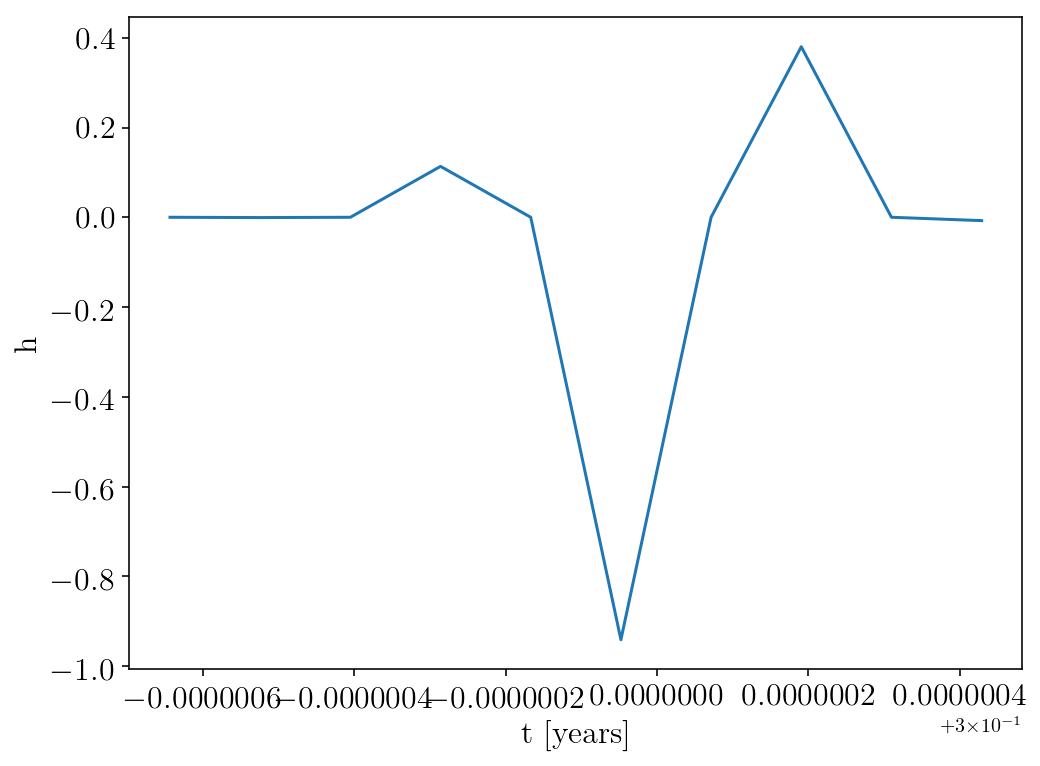

In [52]:
fig, ax = plt.subplots(1, figsize=(8,6))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
ax.set_xlabel(r't [years]', fontsize=16)
ax.set_ylabel(r'h', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

ax.plot(wave.t/l.YEAR, wave.h)

plt.show()

19.1637151869


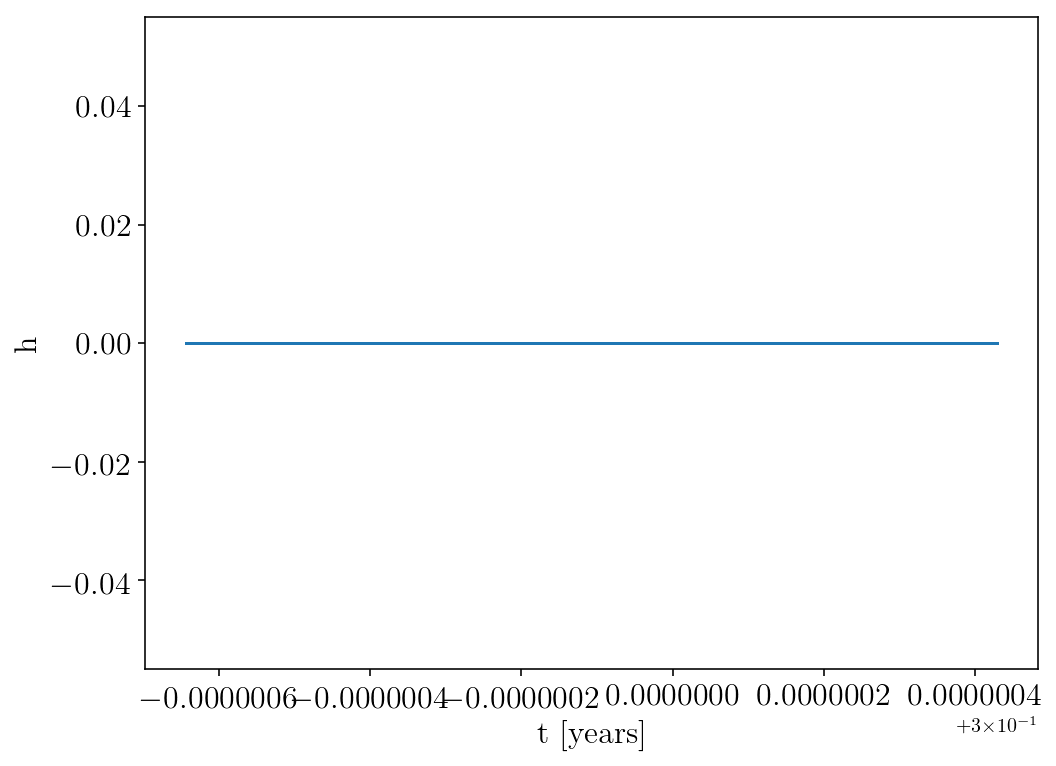

In [53]:
# set up parameters of wavelet
A    = 0.0
# f0   = 20.0e-3
# tau  = 0.07*3600.
# t0   = 0.5*l.YEAR
# phi0 = 0.0

print np.pi*f0*tau

wave2 = gl.Wavelet(A, f0, tau, t0, phi0)
wave2.set_indexes(orb)
wave2.set_t_h(orb)

# drop in the wavelet time series into the data stream
wave2.make_padded_h(t)

fig, ax = plt.subplots(1, figsize=(8,6))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
ax.set_xlabel(r't [years]', fontsize=16)
ax.set_ylabel(r'h', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

ax.plot(wave2.t/l.YEAR, wave2.h)

plt.show()

In [54]:
phi = np.pi*0.2
theta = np.pi*0.25
psi = np.pi*0.23

gw = gl.GW_glitch(wave, wave2, theta, phi, psi, orb)

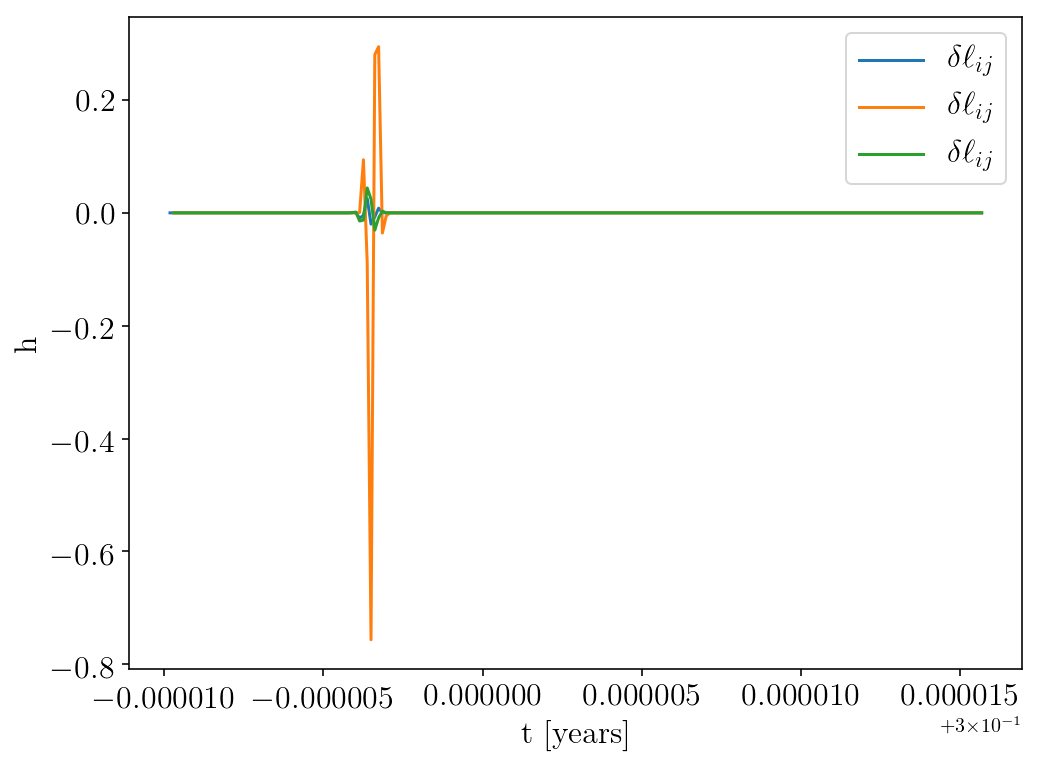

In [55]:
fig, ax = plt.subplots(1, figsize=(8,6))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
ax.set_xlabel(r't [years]', fontsize=16)
ax.set_ylabel(r'h', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

ax.plot(gw.t/l.YEAR, gw.delta_l[0,2], label=r'$\delta\ell_{ij}$')
ax.plot(gw.t/l.YEAR, gw.delta_l[0,1], label=r'$\delta\ell_{ij}$')
ax.plot(gw.t/l.YEAR, gw.delta_l[1,2], label=r'$\delta\ell_{ij}$')

ax.legend(loc='upper right', fontsize=16)

plt.show()

In [61]:
(720.76 - 77.19-(673.17 - 4./6.*570.40))/4.

87.66666666666666

In [56]:
gw.make_padded_delta_l(t)

p12 = gl.Phase(1,2, t, gw.delta_l_padded[0,1,:])
p21 = gl.Phase(2,1, t, gw.delta_l_padded[1,0,:])

p13 = gl.Phase(1,3, t, gw.delta_l_padded[0,2,:])
p31 = gl.Phase(3,1, t, gw.delta_l_padded[2,0,:])

p23 = gl.Phase(2,3, t, gw.delta_l_padded[1,2,:])
p32 = gl.Phase(3,2, t, gw.delta_l_padded[2,1,:])
   
p12.FT_phase(orb)
p21.FT_phase(orb)
p13.FT_phase(orb)
p31.FT_phase(orb)
p23.FT_phase(orb)
p32.FT_phase(orb)

tdi_GW = gl.TDI(p12, p21, p13, p31, p23, p32, orb)

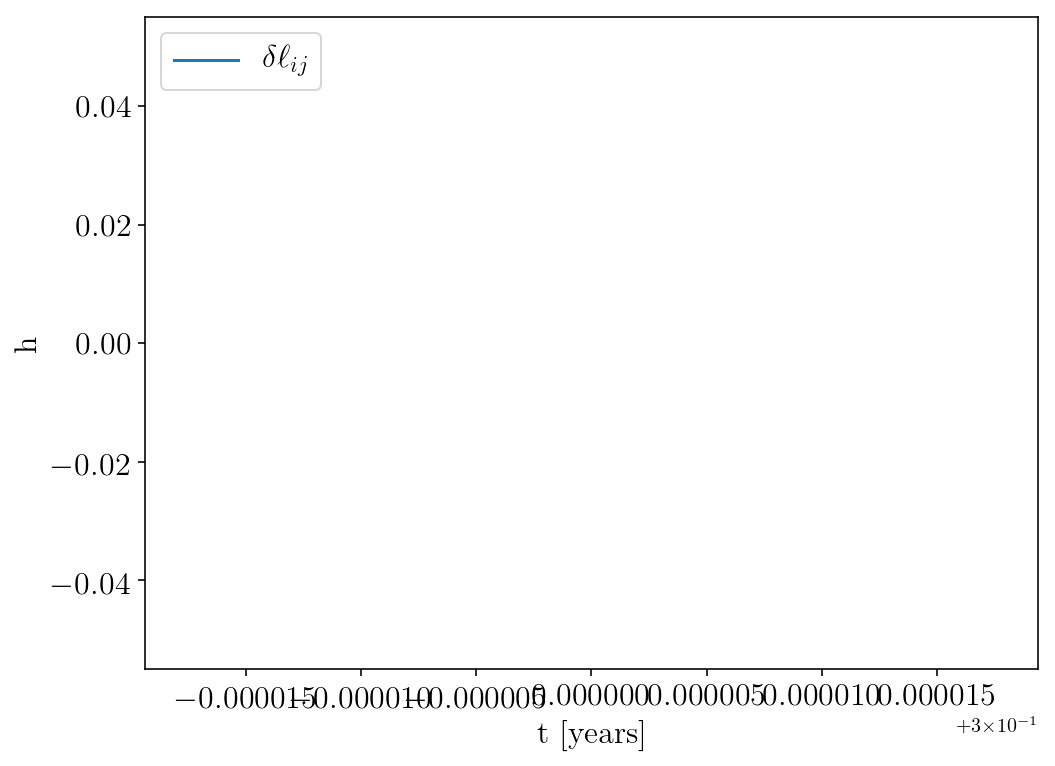

In [57]:
noise = np.fft.irfft(tdi_GW.X)

fig, ax = plt.subplots(1, figsize=(8,6))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
ax.set_xlabel(r't [years]', fontsize=16)
ax.set_ylabel(r'h', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

ax.plot(t[1:-1]/l.YEAR, noise.real, label=r'$\delta\ell_{ij}$')

ax.legend(loc='upper left', fontsize=16)

plt.xlim((wave.t0 - 100.*wave.tau)/l.YEAR, (wave.t0 + 100.*wave.tau)/l.YEAR)

plt.show()

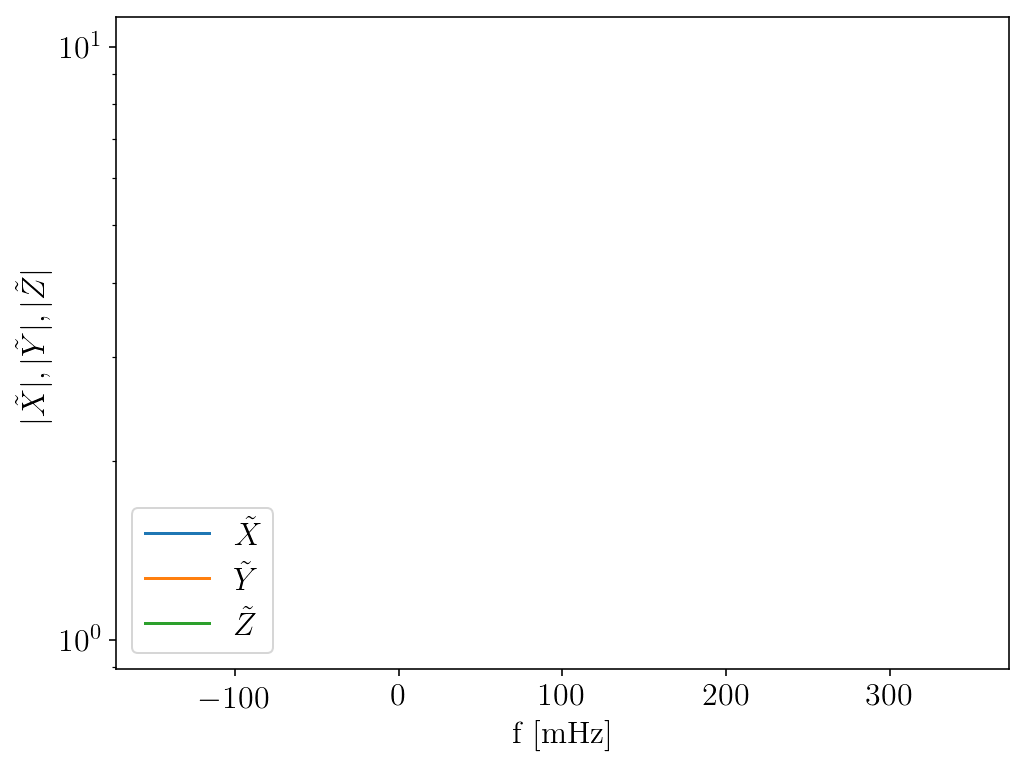

In [9]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

ax.set_xlabel(r'f [mHz]',fontsize=16)
ax.set_ylabel(r'$|\tilde{X}|,|\tilde{Y}|,|\tilde{Z}|$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

mult = 1000.
plt.xlim(gw.hp_wavelet.f_min*mult, gw.hp_wavelet.f_max*mult)

ax.semilogy(tdi_GW.freqs*mult, np.abs(tdi_GW.X), label=r'$\tilde{X}$')
ax.semilogy(tdi_GW.freqs*mult, np.abs(tdi_GW.Y), label=r'$\tilde{Y}$')
ax.semilogy(tdi_GW.freqs*mult, np.abs(tdi_GW.Z), label=r'$\tilde{Z}$')

plt.legend(loc='lower left', fontsize=16)

plt.show()

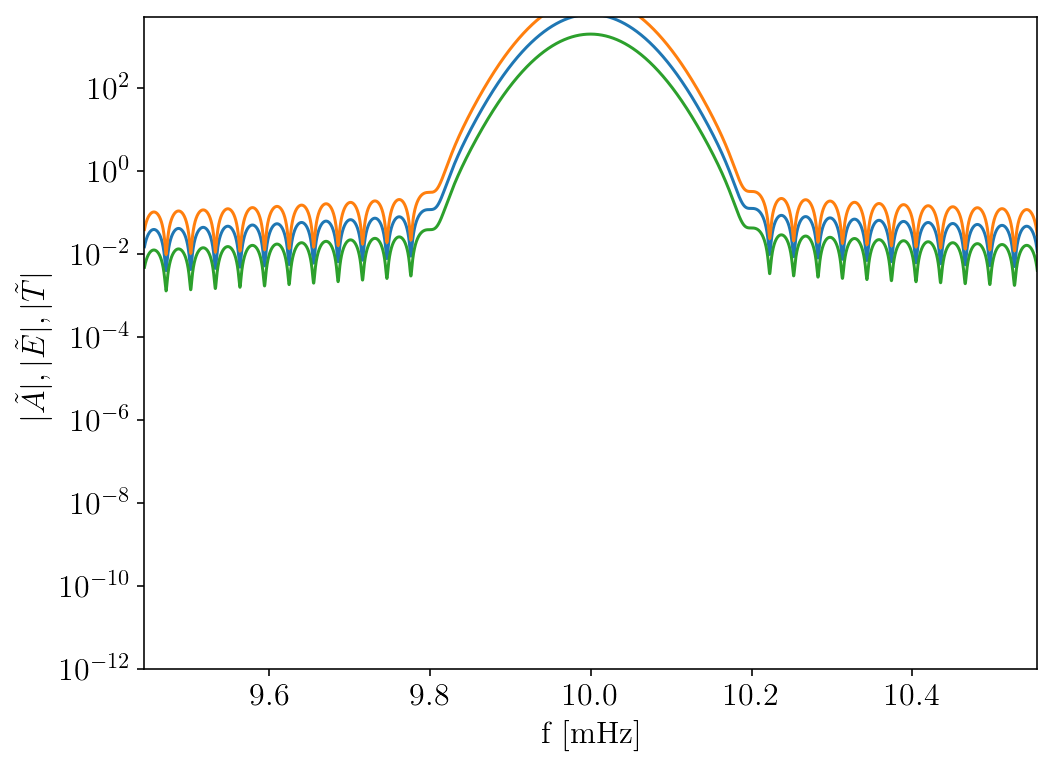

In [99]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

ax.set_xlabel(r'f [mHz]',fontsize=16)
ax.set_ylabel(r'$|\tilde{A}|,|\tilde{E}|,|\tilde{T}|$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

mult = 1000.
plt.xlim(gw.hp_wavelet.f_min*mult, gw.hp_wavelet.f_max*mult)

ax.semilogy(tdi_GW.freqs*mult, np.abs(tdi_GW.A))
ax.semilogy(tdi_GW.freqs*mult, np.abs(tdi_GW.E))
ax.semilogy(tdi_GW.freqs*mult, np.abs(tdi_GW.T))

plt.ylim(1.0e-12, 5.0e3)

plt.show()

In [100]:
%timeit gl.GW_glitch(wave, wave2, theta, phi, psi, orb)

The slowest run took 5.30 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 2.09 ms per loop


In [139]:
p12 = gl.Phase(1,2, t, h)
p12.FT_phase(orb)

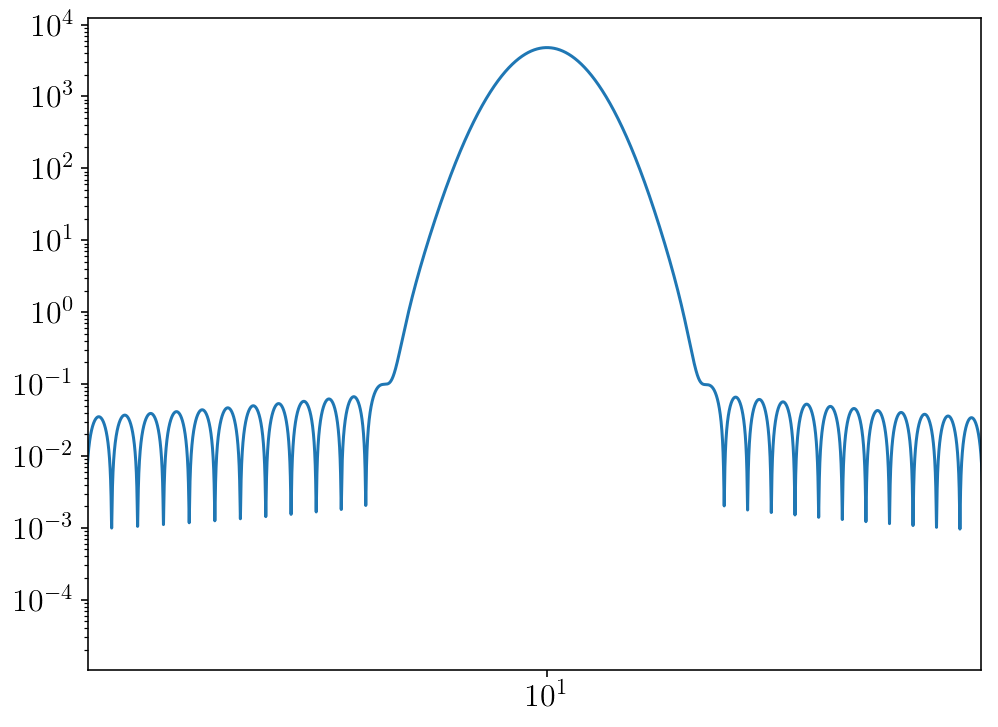

In [102]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
ax.tick_params(axis='both', which='major', labelsize=16)

mult = 1000.
if wave.f_min*mult < 0.0:
    low = 1./orb.dt
else:
    low = wave.f_min*mult
plt.xlim(low, wave.f_max*mult)

ax.loglog(p12.freqs*mult, np.abs(p12.phi_FT))


plt.show()

In [16]:
p12 = gl.Phase(1,2, t, h)
p12.FT_phase(orb)

p21 = gl.Phase(1,2, t, np.zeros(len(t)))

p13 = gl.Phase(1,2, t, np.zeros(len(t)))
p31 = gl.Phase(1,2, t, np.zeros(len(t)))

p23 = gl.Phase(1,2, t, np.zeros(len(t)))
p32 = gl.Phase(1,2, t, np.zeros(len(t)))
               
p21.FT_phase(orb)
p13.FT_phase(orb)
p31.FT_phase(orb)
p23.FT_phase(orb)
p32.FT_phase(orb)

tdi = gl.TDI(p12, p21, p13, p31, p23, p32, orb)

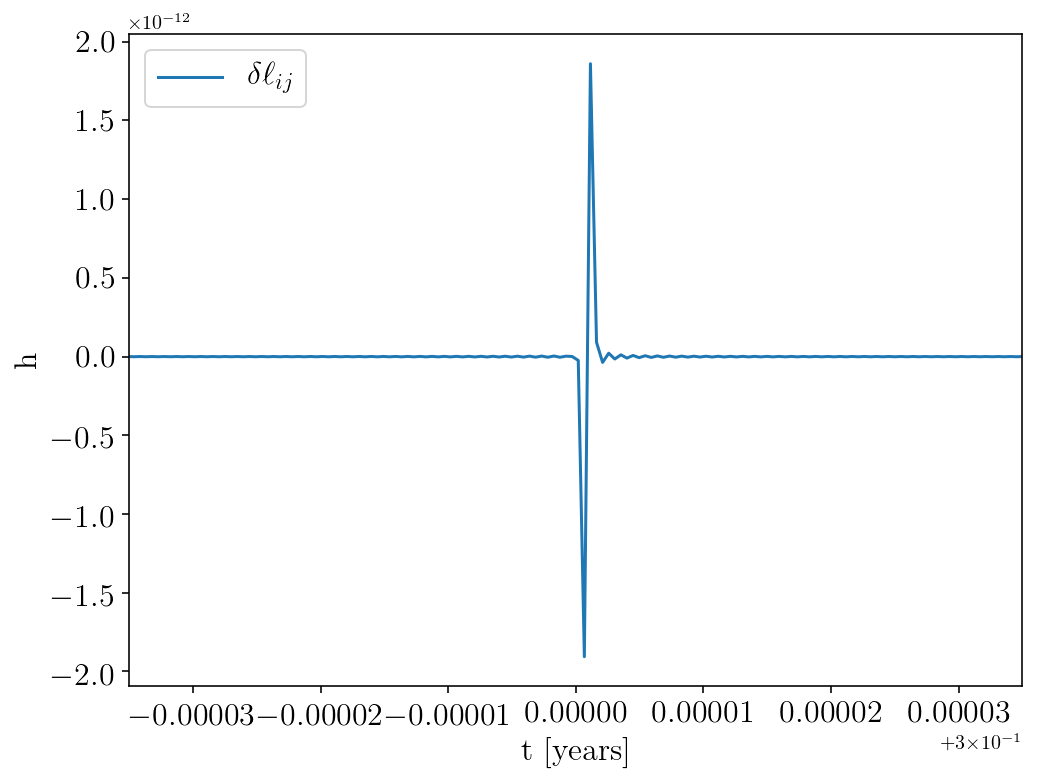

In [20]:
noise = np.fft.irfft(tdi.X)

fig, ax = plt.subplots(1, figsize=(8,6))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
ax.set_xlabel(r't [years]', fontsize=16)
ax.set_ylabel(r'h', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

ax.plot(t[1:-1]/l.YEAR, noise.real, label=r'$\delta\ell_{ij}$')

ax.legend(loc='upper left', fontsize=16)

plt.xlim((wave.t0 - 1000.*wave.tau)/l.YEAR, (wave.t0 + 1000.*wave.tau)/l.YEAR)

plt.show()

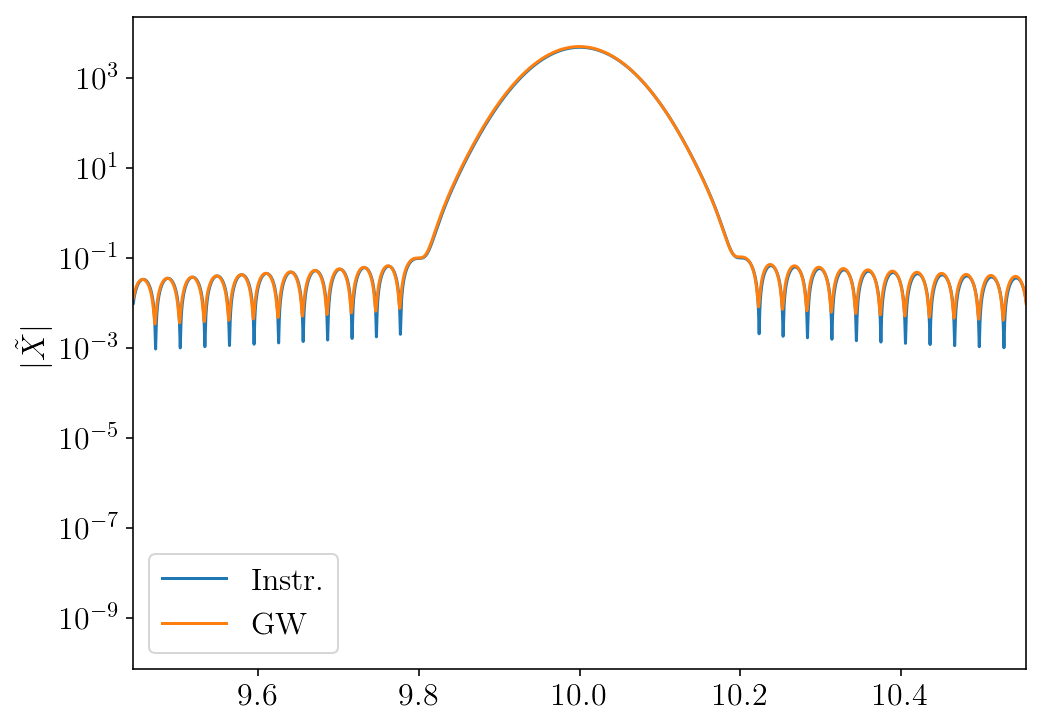

In [104]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

ax.set_ylabel(r'$|\tilde{X}|$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

mult = 1000.
plt.xlim(wave.f_min*mult, wave.f_max*mult)

ax.semilogy(tdi.freqs*mult, np.abs(tdi.X), label=r'Instr.')
ax.semilogy(tdi_GW.freqs*mult, np.abs(tdi_GW.X), label=r'GW')

ax.legend(loc='lower left',fontsize=16)

plt.show()

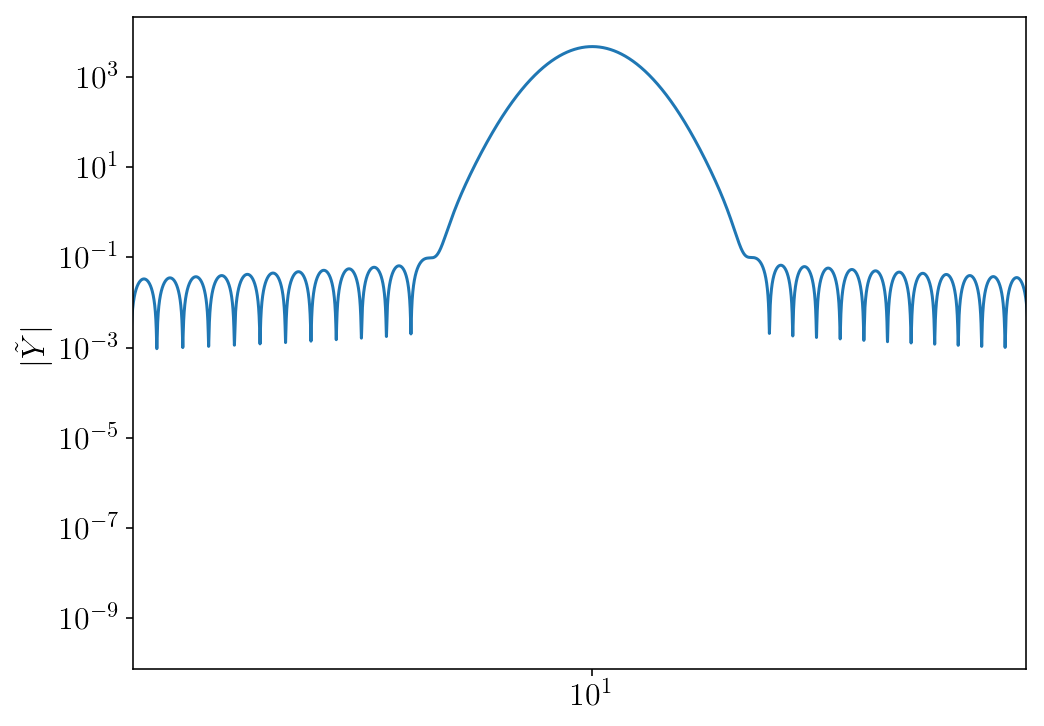

In [105]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

ax.set_ylabel(r'$|\tilde{Y}|$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

mult = 1000.
plt.xlim(wave.f_min*mult, wave.f_max*mult)

ax.loglog(tdi.freqs*mult, np.abs(tdi.Y))


plt.show()

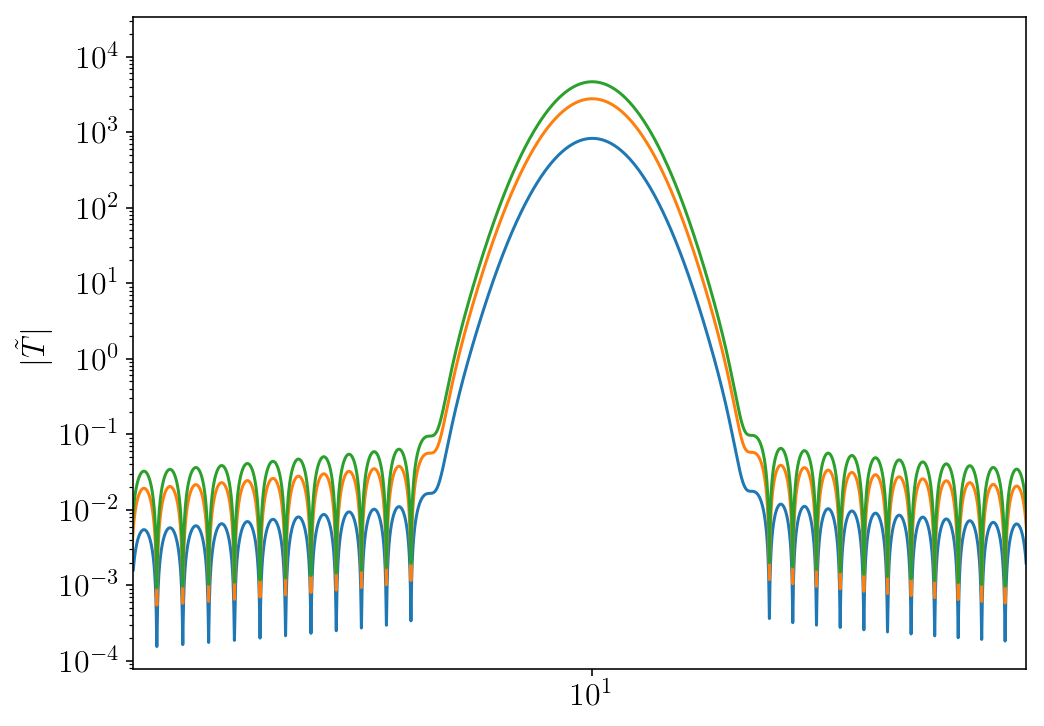

In [106]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

ax.set_ylabel(r'$|\tilde{T}|$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

mult = 1000.
plt.xlim(wave.f_min*mult, wave.f_max*mult)

ax.semilogy(tdi.freqs*mult, np.abs(tdi.T))

mask = (tdi.freqs > wave.f_min) & (tdi.freqs < wave.f_max) 
plt.ylim(0.5*np.min(np.abs(tdi.T[mask])), 40.5*np.max(np.abs(tdi.T[mask]))   )

ax.loglog(tdi.freqs*mult, np.abs(tdi.E))
ax.loglog(tdi.freqs*mult, np.abs(tdi.A))



plt.show()

In [107]:
mask = (tdi.freqs>1.0e-3) & (tdi.freqs<5.0e-3)
noise = orb.get_Sn(tdi.freqs[mask])

In [108]:
snr_GW_X = 4.0*np.sum( tdi_GW.X[mask]*np.conjugate(tdi_GW.X[mask])/noise).real/gw.N/orb.dt
print snr_GW_X

snr_GW_Y = 4.0*np.sum( tdi_GW.Y[mask]*np.conjugate(tdi_GW.Y[mask])/noise).real/gw.N/orb.dt
print snr_GW_Y

snr_GW_Z = 4.0*np.sum( tdi_GW.Z[mask]*np.conjugate(tdi_GW.Z[mask])/noise).real/gw.N/orb.dt
print snr_GW_Z

7.96363208324e+35
6.38028373371e+36
1.08091778007e+37


In [109]:
snr_GW = snr_GW_X + snr_GW_Y + snr_GW_Z
print np.sqrt(snr_GW)

4.240969788e+18


In [86]:
snr_X = 4.0*np.sum( tdi.X[mask]*np.conjugate(tdi.X[mask])/noise).real/gw.N/orb.dt
print snr_X

snr_Y = 4.0*np.sum( tdi.Y[mask]*np.conjugate(tdi.Y[mask])/noise).real/gw.N/orb.dt
print snr_Y

snr_Z = 4.0*np.sum( tdi.Z[mask]*np.conjugate(tdi.Z[mask])/noise).real/gw.N/orb.dt
print snr_Z

2.8185735754e+36
2.8185735754e+36
0.0


In [87]:
snr = snr_X + snr_Y + snr_Z
print np.sqrt(snr)

2.37426770832e+18


In [88]:
overlap_X = 4.0*np.sum( tdi.X[mask]*np.conjugate(tdi_GW.X[mask])/noise ).real/gw.N/orb.dt
print overlap_X/np.sqrt(snr*snr_GW)

overlap_Y = 4.0*np.sum( tdi.Y[mask]*np.conjugate(tdi_GW.Y[mask])/noise ).real/gw.N/orb.dt
print overlap_Y/np.sqrt(snr*snr_GW)

overlap_Z = 4.0*np.sum( tdi.Z[mask]*np.conjugate(tdi_GW.Z[mask])/noise ).real/gw.N/orb.dt
print overlap_Z/np.sqrt(snr*snr_GW)


-0.0822248744008
0.401990022096
0.0


In [89]:
overlap = overlap_X + overlap_Y + overlap_Z

print overlap/np.sqrt(snr*snr_GW)

0.319765147696
